Author: Cezary Januszek

*Created on Saturday, November 11th 2023*
# [Swisscom challenge] Flight delays prediction

#### Research question: *What is the influence of the different airlines/airports on the flight delays?*

The goal of this challenge is to investigate US flight delays and cancellations data from 2015.

First some exploratory data analysis is done to try to find some insights from general statistics about the airlines, airports and average flight delays. Second, using this same data the goal consists in creating a flight delay prediction model by implementing a:
1) baseline model 
2) complex model (Neural Network or other Deep Learning method)

The second model should have better performance than the baseline due to its increased complexity, which will make it also more difficult to explain its predictions.Therefore, an interpretability framework will be added to the second model to allow explicability of the created predictions.

# III. Baseline predicton model

In this notebook, we build the baseline flight delay prediction model. As mentioned in the previous steps, our delays are defined only by the arrival delays of the flights. Moreover, the arrival delays are probably correlated with the departure delays as the already provide important information about the potential final delay of the flight. Therefore, we will check the correlation between these two delay measures and decide to drop the departure delay feature based on the outcome, to ensure that we do not provide to our model to much information about the predicted value (arrival delay).

To solve our flight prediction problem, a **classification model** will allow passengers to predict if their flight would be delayed or not.

The pipeline to build our baseline regression model is as follows:
1. Data pre-processing for feature cleaning and extraction
2. Train-test split
3. Choosing the model and hyperparameters tuning
4.



-----------------------------
Glossary of *flights_df* feature columns:
   - *AIRLINE*: IATA CODE for the airline
   - *ORIGIN_AIRPORT and DESTINATION_AIRPORT*: origin and destination airport of the flight
   - *SCHEDULED_DEPARTURE and SCHEDULED_ARRIVAL*: scheduled times and date of flight departure and landing
   - *DEPARTURE_TIME and ARRIVAL_TIME*: actual real times of flight takeoff and landing
   - *DATE_OF_WEEK*: day of week of scheduled flight
   - *DEPARTURE_DELAY and ARRIVAL_DELAY*: differences between scheduled and real times of flight departure and arrival
   - *DISTANCE*: travel distance between origin and destination airports (in miles)
   - *SCHEDULED_TIME*: scheduled travel time between origin and destination airports

In [97]:
# Imports
%load_ext autoreload
%autoreload 2

from IPython.core.pylabtools import figsize
figsize(10, 8)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import datetime
import math
from collections import Counter
from helper_functions import *

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import lime
from lime import lime_tabular


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
# Load data
flights_df = pd.read_pickle(os.path.abspath('./Data/flights.pkl'))
airports_df = pd.read_pickle(os.path.abspath('./Data/airports.pkl'))
airlines_df = pd.read_csv(os.path.abspath('./Data/airlines.csv'))
                          

### Data pre-processing for classification

For the task of classification we need to extract some information from dates and hours to put them in simple numerical values as well as we should encode categorical factors (airline, airport).

In [99]:
# extract day, month from dates and hour, minutes from time
flights_df['DEPARTURE_DAY'] = flights_df['DATE'].apply(lambda x: x.day)
flights_df['DEPARTURE_MONTH'] = flights_df['DATE'].apply(lambda x: x.month)

flights_df['ARRIVAL_DAY'] = flights_df['ARRIVAL_DATE'].apply(lambda x: x.day)
flights_df['ARRIVAL_MONTH'] = flights_df['ARRIVAL_DATE'].apply(lambda x: x.month)

flights_df['SCHEDULED_DEPARTURE_HOUR'] = flights_df['SCHEDULED_DEPARTURE'].apply(lambda x: x.hour)
flights_df['SCHEDULED_DEPARTURE_MIN'] = flights_df['SCHEDULED_DEPARTURE'].apply(lambda x: x.minute)

flights_df['SCHEDULED_ARRIVAL_HOUR'] = flights_df['SCHEDULED_ARRIVAL'].apply(lambda x: x.hour)
flights_df['SCHEDULED_ARRIVAL_MIN'] = flights_df['SCHEDULED_ARRIVAL'].apply(lambda x: x.minute)

flights_df = flights_df.drop(['DATE', 'ARRIVAL_DATE', 'SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL'], axis=1)

# cyclical encoding
#flights_df = cyclical_encode(flights_df, 'DEPARTURE_DAY', 31)
#flights_df = cyclical_encode(flights_df, 'DEPARTURE_MONTH', 12)
#flights_df = cyclical_encode(flights_df, 'ARRIVAL_DAY', 31)
#flights_df = cyclical_encode(flights_df, 'ARRIVAL_MONTH', 12)

#flights_df = cyclical_encode(flights_df, 'SCHEDULED_DEPARTURE_HOUR', 24)
#flights_df = cyclical_encode(flights_df, 'SCHEDULED_DEPARTURE_MIN', 60)
#flights_df = cyclical_encode(flights_df, 'SCHEDULED_ARRIVAL_HOUR', 24)
#flights_df = cyclical_encode(flights_df, 'SCHEDULED_ARRIVAL_MIN', 60)

#flights_df = flights_df.drop(['DEPARTURE_DAY', 'DEPARTURE_MONTH', 'ARRIVAL_DAY', 'ARRIVAL_MONTH',
#                             'SCHEDULED_DEPARTURE_HOUR', 'SCHEDULED_DEPARTURE_MIN', 'SCHEDULED_ARRIVAL_HOUR', 'SCHEDULED_ARRIVAL_MIN'], axis=1)

In [100]:
# Add mean route-airline departure delay
mean_route_delays = flights_df.groupby(['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'AIRLINE'])['DEPARTURE_DELAY'].mean()
mean_route_delays.name = 'MEAN_ROUTE_DELAY'
flights_df = flights_df.merge(mean_route_delays, left_on=['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'AIRLINE'], right_index=True)

In [101]:
# Compute the mean taxi-ou time for each origin airport and taxi-out time for each destination airport
mean_taxi_out_origin = flights_df.groupby('ORIGIN_AIRPORT')['TAXI_OUT'].mean()
mean_taxi_in_destination = flights_df.groupby('DESTINATION_AIRPORT')['TAXI_IN'].mean()
mean_taxi = pd.DataFrame(mean_taxi_out_origin).join(mean_taxi_in_destination, how='inner')
mean_taxi.columns = ['MEAN_TAXI_OUT_ORIGIN', 'MEAN_TAXI_IN_DESTINATION']

flights_df = flights_df.merge(mean_taxi['MEAN_TAXI_OUT_ORIGIN'], left_on='ORIGIN_AIRPORT', right_index=True)
flights_df = flights_df.merge(mean_taxi['MEAN_TAXI_IN_DESTINATION'], left_on='DESTINATION_AIRPORT', right_index=True)

flights_df = flights_df.drop(['TAXI_IN', 'TAXI_OUT'], axis=1)

In [102]:
# we also drop DEPARTURE_TIME and DEPARTURE_DELAY as both these features are strongly correlated with our target variable - arrival delay
# ARRIVAL_TIME is dropped as well as it indicates almost directly our arrival delay
flights_df = flights_df.drop(['DEPARTURE_TIME', 'ARRIVAL_TIME'], axis=1)

In [103]:
# limit the data to only flights between airports in the top 20 with the most flights
# limitation is due to the high number of flights
top20_airports = flights_df.groupby('ORIGIN_AIRPORT')['ARRIVAL_DELAY'].count().sort_values(ascending=False).head(20).index
flights_df = flights_df[flights_df['ORIGIN_AIRPORT'].isin(top20_airports)]
flights_df = flights_df[flights_df['DESTINATION_AIRPORT'].isin(top20_airports)].reset_index(drop=True)


In [104]:
# create label encoding and decoding dictionaries for airports

#airports_decoding = flights_df.groupby('ORIGIN_AIRPORT')['ARRIVAL_DELAY'].count().sort_values().reset_index()['ORIGIN_AIRPORT'].to_dict()
#airports_encoding = {v: k for k, v in airports_decoding.items()}

# encode airlines and airports
#flights_df['AIRLINE'] = flights_df['AIRLINE'].map(airlines_encoding)

#flights_df['ORIGIN_AIRPORT'] = flights_df['ORIGIN_AIRPORT'].map(airports_encoding)
#flights_df['DESTINATION_AIRPORT'] = flights_df['DESTINATION_AIRPORT'].map(airports_encoding)

In [105]:
flights_df

,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,SCHEDULED_TIME,DISTANCE,ARRIVAL_DELAY,DEPARTURE_DAY,DEPARTURE_MONTH,ARRIVAL_DAY,ARRIVAL_MONTH,SCHEDULED_DEPARTURE_HOUR,SCHEDULED_DEPARTURE_MIN,SCHEDULED_ARRIVAL_HOUR,SCHEDULED_ARRIVAL_MIN,MEAN_ROUTE_DELAY,MEAN_TAXI_OUT_ORIGIN,MEAN_TAXI_IN_DESTINATION
0,4,Alaska Airlines Inc.,LAX,SEA,-5.0,170.0,954,-9.0,1,1,1,1,6,0,8,50,1.007848,16.889625,8.014261
1,4,Alaska Airlines Inc.,LAX,SEA,-5.0,170.0,954,-15.0,1,1,1,1,7,0,9,50,1.007848,16.889625,8.014261
2,4,Alaska Airlines Inc.,LAX,SEA,-1.0,167.0,954,-7.0,1,1,1,1,8,40,11,27,1.007848,16.889625,8.014261
3,4,Alaska Airlines Inc.,LAX,SEA,-7.0,164.0,954,-18.0,1,1,1,1,10,30,13,14,1.007848,16.889625,8.014261
4,4,Alaska Airlines Inc.,LAX,SEA,82.0,154.0,954,96.0,1,1,1,1,13,0,15,34,1.007848,16.889625,8.014261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395659,4,Delta Air Lines Inc.,DTW,LGA,1.0,103.0,502,-8.0,31,12,31,12,15,23,17,6,11.770922,18.069613,8.841586
1395660,4,Delta Air Lines Inc.,DTW,LGA,29.0,106.0,502,14.0,31,12,31,12,19,40,21,26,11.770922,18.069613,8.841586
1395661,7,Atlantic Southeast Airlines,DTW,LGA,43.0,103.0,502,61.0,4,1,4,1,21,40,23,23,11.000000,18.069613,8.841586
1395662,4,Atlantic Southeast Airlines,DTW,LGA,-6.0,109.0,502,-15.0,26,11,26,11,15,40,17,29,11.000000,18.069613,8.841586


### Classification model - baseline

To define if a flight is delayed on arrival a threshold needs to be set. The US Federal Aviation Administration considers the flight to be delayed on arrival when it is 15 min later than its scheduled time.

In [106]:
data = flights_df.copy()
#data['FLIGHT_DELAY'] = (data['ARRIVAL_DELAY'] > 15).apply(int)
data['ARRIVAL_DELAY'] = data['ARRIVAL_DELAY'].apply(lambda x: set_delay_class(x))

<Axes: xlabel='ARRIVAL_DELAY'>

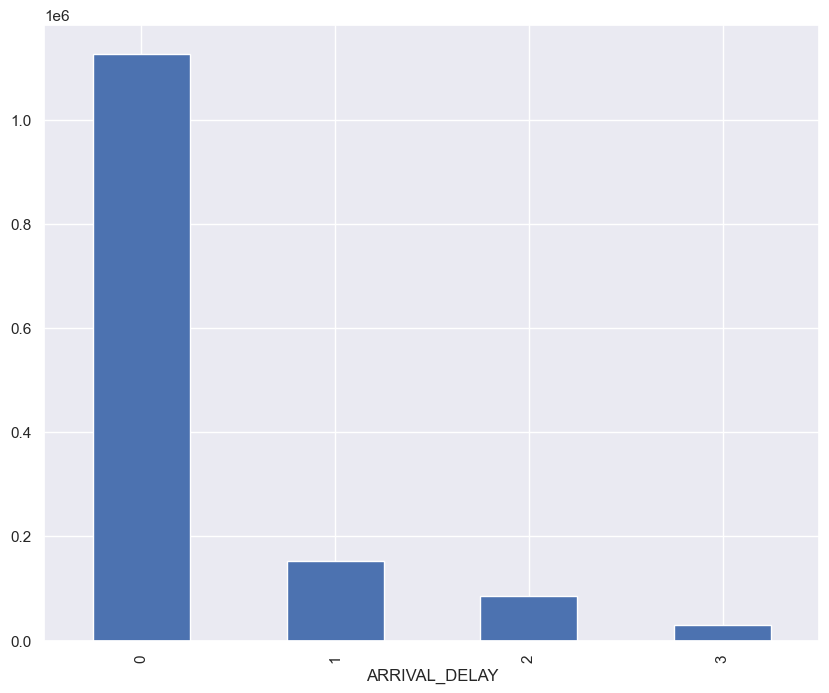

In [107]:
# as we have strong class imbalance weighted precision, recall and f1-score will be used
data.groupby('ARRIVAL_DELAY')[data.columns[0]].count().plot.bar()

### Without DEPARTURE_DELAY feature

In [90]:
# separate data into feature matrix X and target variable vector Y
X = pd.get_dummies(data.drop('ARRIVAL_DELAY', axis=1))
Y = data['ARRIVAL_DELAY']

In [91]:
# train-test split with test size of 0.3
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
print('Train samples: ', X_train.shape[0])
print('Test samples: ', X_test.shape[0])

Counter(Y_train)

Train samples:  976964
Test samples:  418700


Counter({0: 788206, 1: 107369, 2: 59902, 3: 21487})

In [93]:
# Addressing class imbalance with oversampling the minority classes with SMOTE and undersampling the majority class
#undersample = RandomUnderSampler(sampling_strategy='majority')
#X_train, Y_train = undersample.fit_resample(X_train, Y_train)
#Counter(Y_train)

In [94]:
# define the model
clf_model = DecisionTreeClassifier(class_weight='balanced')

#params = {
#    'criterion': ['gini', 'entropy', 'log_loss'],
#    'max_depth': [2, 3, 5, 10, 20],
#    'min_samples_leaf': [5, 10, 20, 50, 100]
#}

#clf_cv = GridSearchCV(clf_model, param_grid=params, cv=5)
clf_model.fit(X_train, Y_train)

scores = cross_val_score(clf_model, X_train, Y_train, cv=5)
print('Training accuracy = {:.3f}'.format(scores.mean()))


Training accuracy = 0.694


Cross-entropy loss = 11.001
Accuracy = 0.695
Precision = 0.703
Recall = 0.695
F1-score = 0.699
ROC-AUC = 0.568


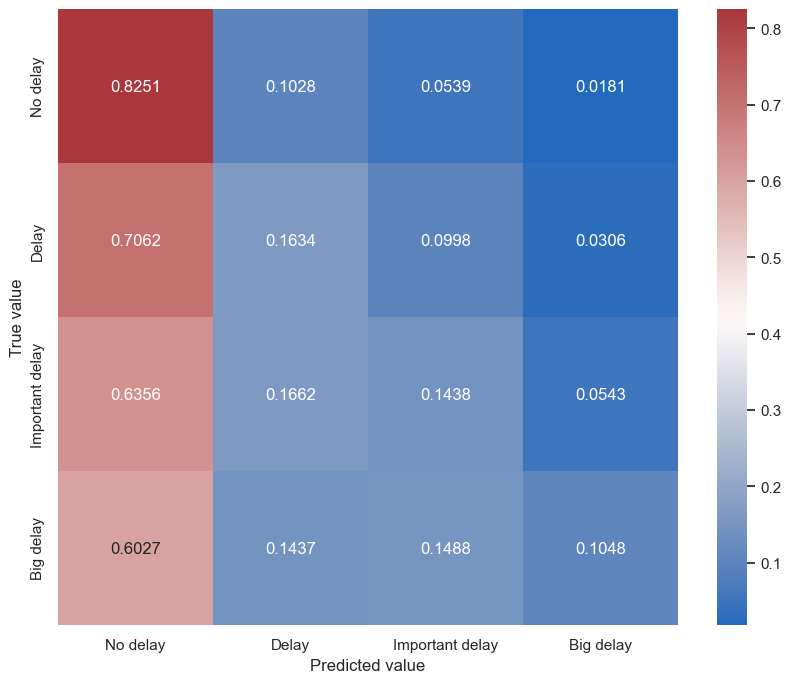

In [96]:
# evaluate metrics
y_pred, y_pred_proba = clf_evaluate_metrics(clf_model, X_test, Y_test)

### With DEPARTURE_DELAY feature

With DELAY_DEPARTURE:
R-squared = 0.898
Cross-entropy loss = 3.681
Accuracy = 0.898
Precision = 0.713
Recall = 0.719
F1-score = 0.716

Without DEPARTURE_DELAY:
R-squared = 0.758
Cross-entropy loss = 8.674
Accuracy = 0.759
Precision = 0.328
Recall = 0.327
F1-score = 0.327


Multi-class without DELAY_DEPARTURE:
Cross-entropy loss = 10.233
Accuracy = 0.716
Precision = 0.725
Recall = 0.716
F1-score = 0.720

Multi-class with DELAY_DEPARTURE:
R-squared = 0.870
Cross-entropy loss = 4.667
Accuracy = 0.871
Precision = 0.871
Recall = 0.871
F1-score = 0.871


Mean airport delay:
R-squared = 0.715
Cross-entropy loss = 10.241
Accuracy = 0.716
Precision = 0.725
Recall = 0.716
F1-score = 0.720
ROC-AUC = 0.576

In [154]:
n = 16

# Explaining model using LIME
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns,
    class_names=['No delay', 'Delay', 'Important delay', 'Big delay'],
    mode='classification'
)
if clf_model.predict(np.array(X_test.iloc[n]).reshape(1,-1)) == Y_test.iloc[n]:
    print('Correct prediction!')
exp = explainer.explain_instance(
    data_row=X_test.values[n], 
    predict_fn=clf_model.predict_proba
)
exp.show_in_notebook(show_table=True)

KeyboardInterrupt: 

### Regression baseline


In [13]:
# filter the outlier delays exceeding 3h
data = flights_df[flights_df['ARRIVAL_DELAY'] < 180]
data['ARRIVAL_DELAY'] = data['ARRIVAL_DELAY'].clip(lower=0)

C:\Users\cezar\AppData\Local\Temp\ipykernel_34604\1860836621.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ARRIVAL_DELAY'] = data['ARRIVAL_DELAY'].clip(lower=0)


In [20]:
# separate data into feature matrix X and target variable vector Y
X = pd.get_dummies(data.drop('ARRIVAL_DELAY', axis=1))
Y = data['ARRIVAL_DELAY'] 

# train-test split with test size of 0.3
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print('Train samples: ', X_train.shape[0])
print('Test samples: ', X_test.shape[0])

# standardizing training data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# polynomial feature extension of degree d
poly_features = PolynomialFeatures(degree=2, include_bias=True).fit(X_train)
X_train = poly_features.transform(X_train)
X_test = poly_features.transform(X_test)

Train samples:  3966302
Test samples:  1699845


In [16]:
# model 
# ELASTICNET
l1_ratio_array = [0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 1]
#alpha_array = np.linspace(0.1, 2, 20)

elasticnet_model = ElasticNetCV(cv=5, l1_ratio = l1_ratio_array)
elasticnet_model.fit(X_train, Y_train)

score = elasticnet_model.score(X_train, Y_train)
print('Training R-squared = {:.3f}'.format(score))

print('Chosen L1 ratio:', elasticnet_model.l1_ratio_)
print('Chosen alpha:', elasticnet_model.alpha_)
print('Coefficients:', elasticnet_model.coef_)

y_pred = elasticnet_model.predict(X_test)
rmse = math.sqrt(mean_squared_error(Y_test, y_pred))
print('RMSE = {:.3f}'.format(rmse))
mae = mean_absolute_error(Y_test, y_pred)
print('MAE = {:.3f}'.format(mae))

Training R-squared = 0.026
Chosen L1 ratio: 1.0
Chosen alpha: 0.003062308101952252
Coefficients: [ 0.00000000e+00 -4.00455196e-01  4.08585196e-01  6.68999380e-01
  2.72847131e-01 -3.72865829e-01 -1.52964802e-01 -9.51053883e-01
 -6.76171236e-03 -0.00000000e+00  2.35454456e+00  1.26291568e-01
  1.03531919e+00  2.23992760e-03 -5.18948671e-01 -1.25059333e-01
  5.27079645e-01  4.19725617e-01 -1.09371501e+00  4.75989632e-01
 -4.46821645e-01  4.75071391e-01  2.60459895e-01 -8.89214984e-02
  9.19928480e-01 -2.73734848e-01  3.35915914e-01 -0.00000000e+00]
RMSE = 23.601
MAE = 13.736
